# 1. Importing Dependencies and Data

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [4]:
# Set up for scaling later on
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [11]:
import tensorflow_datasets as tfds
ds = tfds.load('fashion_mnist', split='train')

2024-02-04 12:57:57.153557: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

2024-02-04 12:58:03.730447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shuffling /Users/ammaar/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5RCVJ6/fashion_mnist-train.tfrecord*…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /Users/ammaar/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5RCVJ6/fashion_mnist-test.tfrecord*.…

Dataset fashion_mnist downloaded and prepared to /Users/ammaar/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# 2. Visualize Data and Building Data Pipeline

In [12]:
# Some data transformation
import numpy as np

In [13]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

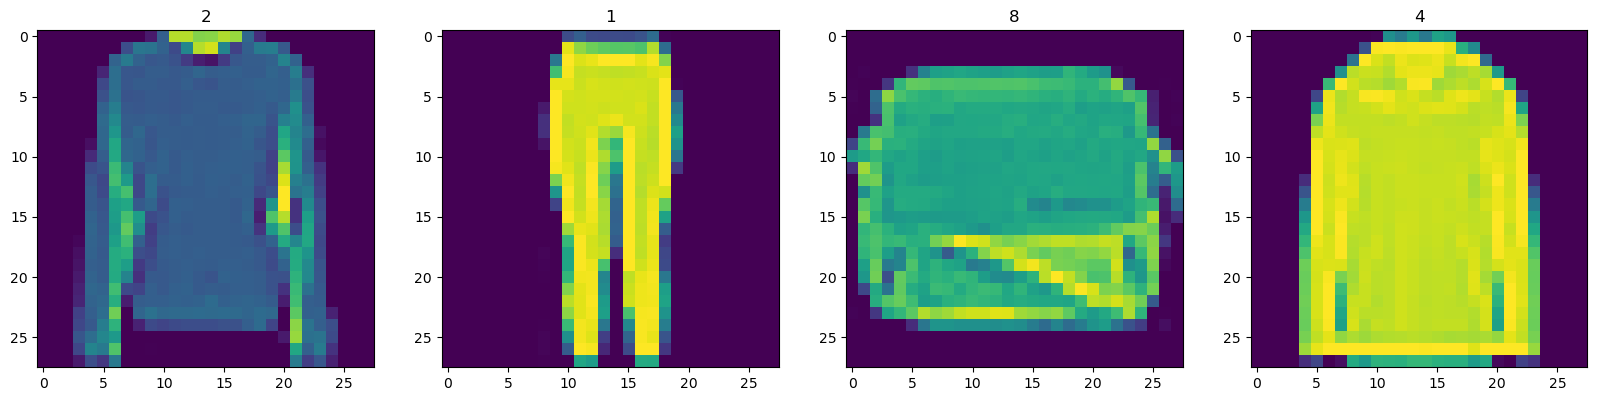

In [14]:
# Creating some subplots for 4 sample images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = dataiterator.next() # Grab an image and label
    ax[idx].imshow(np.squeeze(batch['image'])) # Converting shape to 28x28 (squeeze)
    ax[idx].title.set_text(batch['label'])

In [15]:
# Scale and return images only (preprocessing)
def scale_images(data):
    image = data['image']
    return image / 255

In [16]:
# Reloading the dataset
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images) # Running the dataset through the scale_images preprocessing step
ds = ds.cache() # Cache the dataset for that batch
ds = ds.shuffle(60000) # Shuffle it up
ds = ds.batch(128) # Batch into 128 images per sample
ds = ds.prefetch(64) # Reduces the likelihood of bottlenecking

In [17]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Building Neural Network
- 3.1 Importing modelling components
- 3.2 Building the generator | Think of this as the 'artist'
- 3.3 Building the discriminator | Think of this as the 'art critic'

Importing modelling components

In [18]:
# Bring in the sequential API for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Building the generator

In [39]:
def build_generator():
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated images
    model.add(Dense(7*7*128, input_dim=128)) # Generate based on 128 random values and shape image to 7*7*128
    model.add(LeakyReLU(0.2)) 
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 - 14x14x128
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 - 28x28x128
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convert layer to get to one channel
    model.add(Conv2D(1,4, padding='same', activation='sigmoid')) # Sigmoid(0,1)
    
    return model

In [40]:
test_model = build_generator()

In [41]:
test_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_9 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [60]:
# Testing out the generator
generator = build_generator()
img = generator.predict(np.random.randn(4, 128, 1)) # Generating 4 random images using a normal distribution
img

1/1 [==============================] - 0s 112ms/step


array([[[[0.50258666],
         [0.5091313 ],
         [0.5040207 ],
         ...,
         [0.50287646],
         [0.5054787 ],
         [0.49780166]],

        [[0.49816367],
         [0.5011295 ],
         [0.50087684],
         ...,
         [0.50238067],
         [0.49433962],
         [0.4967994 ]],

        [[0.50369614],
         [0.50390023],
         [0.5068977 ],
         ...,
         [0.501125  ],
         [0.49997452],
         [0.4982915 ]],

        ...,

        [[0.49611092],
         [0.49946237],
         [0.49422637],
         ...,
         [0.50393397],
         [0.4981518 ],
         [0.50078285]],

        [[0.4922454 ],
         [0.49531922],
         [0.49552375],
         ...,
         [0.49876004],
         [0.498305  ],
         [0.5002478 ]],

        [[0.4952063 ],
         [0.49924418],
         [0.50093025],
         ...,
         [0.49701685],
         [0.4983645 ],
         [0.50146925]]],


       [[[0.50225514],
         [0.5084203 ],
         [0.50

In [43]:
img.shape

(4, 28, 28, 1)

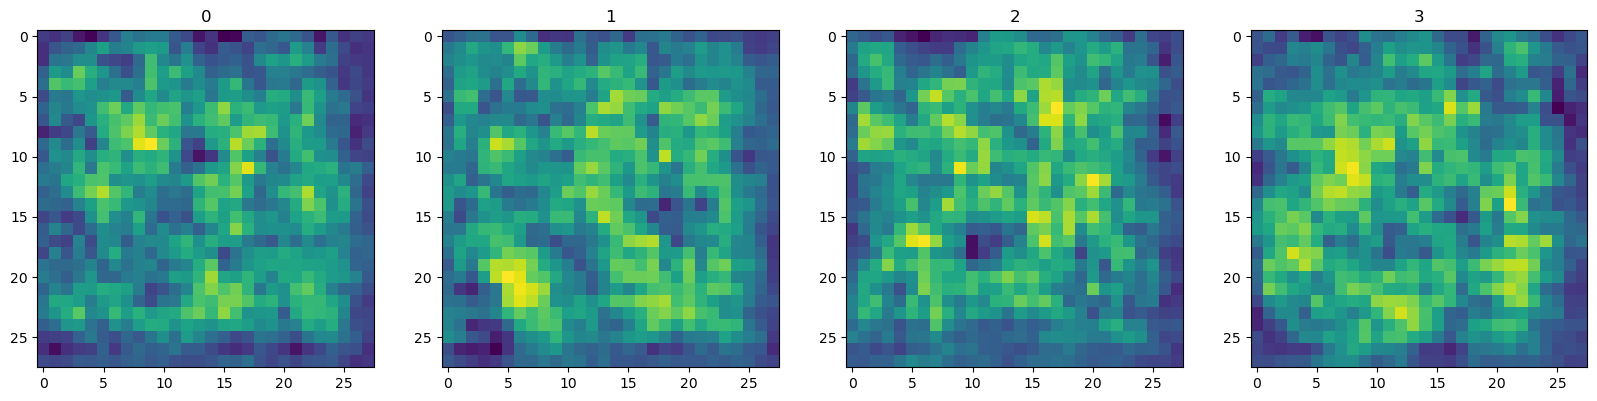

In [44]:
# Creating some subplots for 4 generated images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop 4 times and get images
for idx, img in enumerate(img):
    # Plotting the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as plot title
    ax[idx].title.set_text(idx)

Build Discriminator - Classifiy generated image in to 1: Fake image, 0: Real image

In [48]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [49]:
discriminator = build_discriminator()

In [50]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 128)     

In [61]:
# Testing the discriminator
discriminator.predict(img) # Outputs an array of predictions from 0-1

1/1 [==============================] - 0s 32ms/step


array([[0.49220237],
       [0.49234724],
       [0.49226138],
       [0.49223387]], dtype=float32)

# 4. Construct Training Loop
- 4.1 Setup losses and optimizers
- 4.2 Build subclassed model
- 4.3 Build callback
- 4.4 Train
- 4.5 Review performance

Setup losses and optimizers